In [6]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

In [7]:
# This version is a recreation of the graph at https://gmvoit.github.io/ExpCGM/descriptions/Essentials.html
# but with a slider for alpha, making it range between 1.25 and 2.5

# Constants
A_NFW = 4.625
# Integration lower limit, since some functions starts become hard to integrate when very to close to 0
eps = 10**(-4)

# Defining the functions described in the model, for a constant alpha

def f_P(x, alpha):        
    return np.exp(-alpha * np.log(x))

def vc2(x):
    return np.log(1 + x) / x - 1 / (1 + x)

def phi(x):
    return 1 - np.log(1 + x) / x

def integrandI(t, alpha): # We define the integrands as seperate functions before integrating them
    return f_P(t, alpha) * t**2 / vc2(t)

def I(x, alpha):        
    resultI, _ = integrate.quad(integrandI, eps, x, args=(alpha,), limit=50)
    return alpha / A_NFW * resultI

def integrandJphi(t, alpha):
    return f_P(t, alpha) * phi(t) / vc2(t) * t**2

def Jphi(x, alpha):
    resultJphi, _ = integrate.quad(integrandJphi, eps, x, args=(alpha,), limit=50)
    return alpha * resultJphi

def integrandJth(t, alpha):
    return f_P(t, alpha) * t**2

def Jth(x, alpha):
    resultJth, _ = integrate.quad(integrandJth, eps, x, args=(alpha,), limit=50)
    return 3 / 2 * resultJth

def F(x, alpha):
    return (Jphi(x, alpha) + Jth(x, alpha)) / I(x, alpha)

# Defining a plotting function based on the value of alpha

def update(alpha=1.5):
    x_values = np.logspace(-1.5, 4, 50)
    y_values = [F(x, alpha) for x in x_values]

    plt.figure(figsize=(8, 6))
    plt.plot(y_values, x_values)
    plt.xlim(0, 4.7)
    plt.xscale('linear')
    plt.yscale('log')
    plt.xlabel(r'$\mathrm{E}_{\mathrm{CGM}} \ / \ \mathrm{M}_{\mathrm{CGM}} \ \mathrm{v}_{\varphi}$', fontsize=12)
    plt.ylabel(r'$x_{\mathrm{CGM}} \ = \ r_\mathrm{CGM} \ / \ r_s$', fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

# Creating an interactive slider
# continuous_update=False makes the graph only update once the slider stops being moved, which can be changed to True.
alpha_slider = FloatSlider(min=1.25, max=2.5, step=0.01, value=1.5, continuous_update=False)
interact(update, alpha=alpha_slider);

interactive(children=(FloatSlider(value=1.5, continuous_update=False, description='alpha', max=2.5, min=1.25, …

In [8]:
# This version makes alpha a function of rmax instead of a constant, as described in https://gmvoit.github.io/ExpCGM/extensions/PressureProfiles.html
# Where rmax is the radius (as a multiple of r_s) at which v_c is maximized in an NFW 

A_NFW = 4.625
eps = 10**(-4)

# We need to redefine our functions so that they depend on rmax instead of alpha

def alpha(x, rmax):
    return (3.4*x)/(rmax + x)

def integrandf_P(t, rmax):
    return alpha(t, rmax) / t

def f_P(x, rmax):        
    resultf_P, _ = integrate.quad(integrandf_P, 1+eps, x, args=(rmax,), limit=50)
    return np.exp(-resultf_P)

def vc2(x):
    return np.log(1+x) / x - 1 / (1+x)

def phi(x):
    return 1- np.log(1+x)/x

def integrandI(t, rmax):
    return alpha(t, rmax) * f_P(t, rmax) * t**2 / vc2(t)

def I(x, rmax):        
    resultI, _ = integrate.quad(integrandI, eps, x, args=(rmax,), limit=50)
    return 1 / A_NFW * resultI

def integrandJphi(t, rmax):
    return alpha(t, rmax) * f_P(t, rmax) * phi(t) / vc2(t) * t**2

def Jphi(x, rmax):
    resultJphi, _ = integrate.quad(integrandJphi, eps, x, args=(rmax,), limit=50)
    return resultJphi

def integrandJth(t, rmax):
    return f_P(t, rmax) * t**2

def Jth(x, rmax):
    resultJth, _ = integrate.quad(integrandJth, eps, x, args=(rmax,), limit=50)
    return 3 / 2 * resultJth

def F(x, rmax):
    return (Jphi(x, rmax) + Jth(x, rmax)) / I(x, rmax)

def update(rmax = 2):
    x_values = np.logspace(-1.5, 4, 50)
    y_values = [F(x, rmax) for x in x_values]

    plt.figure(figsize=(8, 6))
    plt.plot(y_values, x_values)
    plt.xlim(0, 4.7)
    plt.xscale('linear')
    plt.yscale('log')
    plt.xlabel(r'$\mathrm{E}_{\mathrm{CGM}} \ / \ \mathrm{M}_{\mathrm{CGM}} \ \mathrm{v}_{\varphi}$', fontsize=12)
    plt.ylabel(r'$x_{\mathrm{CGM}} \ = \ r_\mathrm{CGM} \ / \ r_s$', fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

rmax_slider = FloatSlider(min=1, max=2.4, step=0.01, value=2, continuous_update=False)
interact(update, rmax=rmax_slider);

interactive(children=(FloatSlider(value=2.0, continuous_update=False, description='rmax', max=2.4, min=1.0, st…

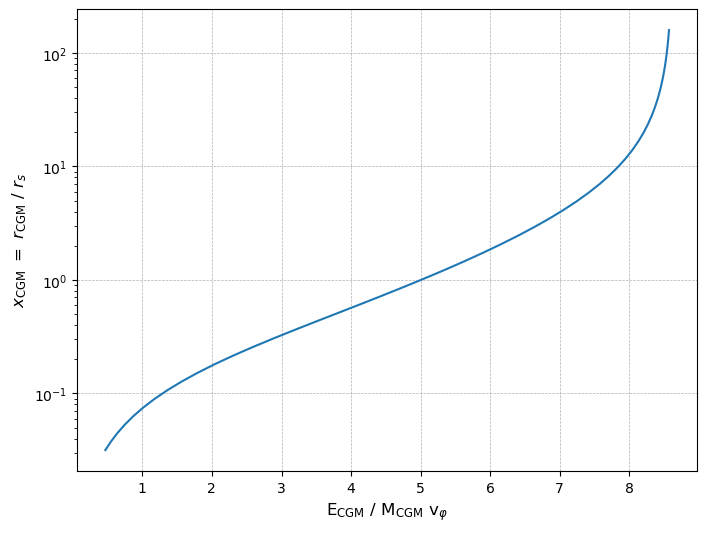

In [9]:
# Finally, this version adds the central galaxy to the rotation curve.
# We do this using the Hernquist model, as described in gmvoit.github.io/ExpCGM/fitting_data/InputParameters.html

A_NFW = 4.625
eps = 10**(-4)
r_H = 0.2 # The Hernquist radius is the radius at which v_c is maximized in the Hernquist model.
rmax = 2.163

# In this version, if we let both v_c^2 and alpha go to 0, the J_phi integral misbehaves causing double values
# One solution to this is to go back to a model with constant alpha.
# Another is to give a lower bound to alpha, taking the maximum of the two functions
# This approach works for down to alpha = ~0.7, though it gives an increasingly jagged graph

def alpha(x, rmax):
    # return 3.4 * ( x/rmax /(1+x/rmax) )   # option 1
    
    return 1.5   # option 2
    
    # alpha1 = 3.4 * ( x/rmax /(1+x/rmax) )
    # alpha2 = 0.7
    # return max(alpha1,alpha2)   # option 3

def integrandf_P(t, rmax):
    return alpha(t, rmax) / t

def f_P(x, rmax):
    resultf_P, _ = integrate.quad(integrandf_P, 1+eps, x, args=(rmax,), limit=50)
    return np.exp(-resultf_P)

# Defining the NFW and Hernquist models seperately, then adding them together

def v2_NFW(x):
    return A_NFW * (np.log(1+x) / x - 1 / (1+x))

def v2_H(x):
    return 4 * r_H * x / (x + r_H)**2

def vc2(x):
    return v2_NFW(x) + v2_H(x)

def integrandphi(t):
    return vc2(t) / t

def phi(x):
    resultphi, _ = integrate.quad(integrandphi, eps, x, limit=50)
    return resultphi

def integrandI(t, rmax):
    return alpha(t, rmax) * f_P(t, rmax) * t**2 / (vc2(t))

def I(x, rmax):        
    resultI, _ = integrate.quad(integrandI, eps, x, args=(rmax), limit=50)
    return resultI

def integrandJphi(t, rmax):
    return alpha(t, rmax) * f_P(t, rmax) * phi(t) / vc2(t) * t**2

def Jphi(x, rmax):
    resultJphi, _ = integrate.quad(integrandJphi, eps, x, args=(rmax), limit=50)
    return resultJphi

def integrandJth(t, rmax):
    return f_P(t, rmax) * t**2

def Jth(x, rmax):
    resultJth, _ = integrate.quad(integrandJth, eps, x, args=(rmax,), limit=50)
    return 3 / 2 * resultJth

def F(x, rmax):
    return (Jth(x, rmax)+Jphi(x, rmax)) / I(x, rmax)

x_values = np.logspace(-1.5, 2.2, 50)
y_values = [F(x,rmax) for x in x_values]

plt.figure(figsize=(8, 6))
plt.plot(y_values, x_values)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel(r'$\mathrm{E}_{\mathrm{CGM}} \ / \ \mathrm{M}_{\mathrm{CGM}} \ \mathrm{v}_{\varphi}$', fontsize=12)
plt.ylabel(r'$x_{\mathrm{CGM}} \ = \ r_\mathrm{CGM} \ / \ r_s$', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

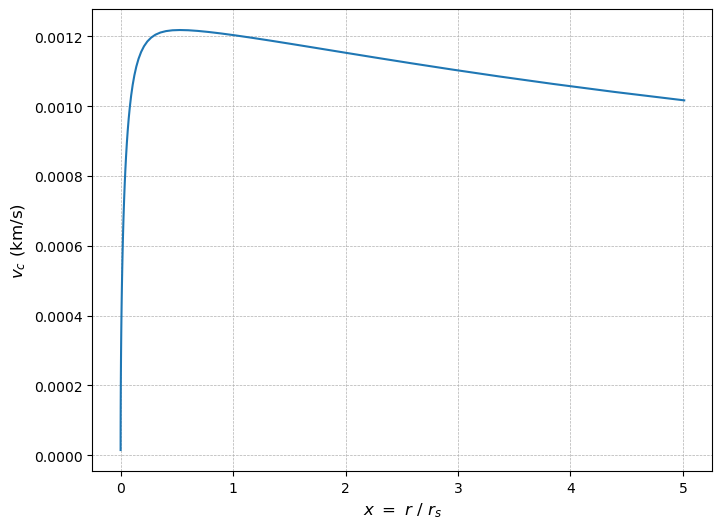

In [10]:
# We can also plot the rotation curve being used

x_values_2 = np.logspace(-5, 0.7, 100)
v_c_values = [np.sqrt(vc2(x))/1e3 for x in x_values_2]

plt.figure(figsize=(8, 6))
plt.plot(x_values_2, v_c_values)
plt.xscale('linear')
plt.yscale('linear')
plt.xlabel(r'$x \ = \ r \ / \ r_s$', fontsize=12)
plt.ylabel(r'$v_c$ (km/s)', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()